# Community Detection
The following notebook will look into community detections in graphs

## Notes from video lecture
### Modularity
A community is intuitavily a dense well-connected group of nodes which is weakly connected to the rest of the graph. And the weak connections should have high betweeness. If the trace is 1 then all links will be inside communities. However, the entire network is seen as one community then the trace is still going to be 1. Hence, we compare to how the links would fall in a random network.

Definition of modularity measure Q:
$$a_{i}=\sum_{j} e_{ij}$$
$$Q = \sum_{i} e_{ii} - a_{i}^2$$

a is fraction of edges that connects to vertices within the community and Q is essentially the trace minus a. The idea here is to say that the trace should be $e_{ij} = a_{i}a_{j}$ if the communities were random. Hence, we say the trace minus what the trace would be if it was a random network. We want to have fewer than expected edges between communities.

### k-cliques
clique is a fully connected subgraph. The algorithm defines a k-clique as adjacent cliques consisting of k nodes and share k-1 edges. Increasing the number of k, makes it possible to find denser and denser communities. This make it possible to have overlapping communities such as multiple friend groups. cfinder can be used to visualize k-cliques.


### Link communities
Newmans impression on how communities cluster is wrong (one node in one communitiy). In real life nodes is in many communities.


(Disclaimer - Sune thinks this is wrong because the properties don't hold  when all nodes are connected to many communities)

strong community:
$$k_{i}^{in}(V) > k_{i}^{out}(V), \forall i \in V.$$

weak community:
$$\sum_{i \in V} k_{i}^{in}(V) > \sum_{i \in V} k_{i}^{out}(V).$$




### Hierarchical Structure
This again runs into trouble with the one node one community idea, given that would entail that you also only can be placed in one particular place in the hiearchy eventhough you usually would be place in many.

The solution is that the nodes should fit within a community but the edges should not.

# Exercises



## Exercise 1  - Karate club

1) Visualize the Karate club dataset and set node color to club split

In [1]:
import networkx as nx
from netwulf import visualize
import matplotlib.pyplot as plt
import netwulf
from networkx import Graph
import networkx.algorithms.community as nx_comm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

In [180]:
def setup_mpl():
    mpl.rcParams['font.family'] = 'Times New Roman'
    return
setup_mpl()

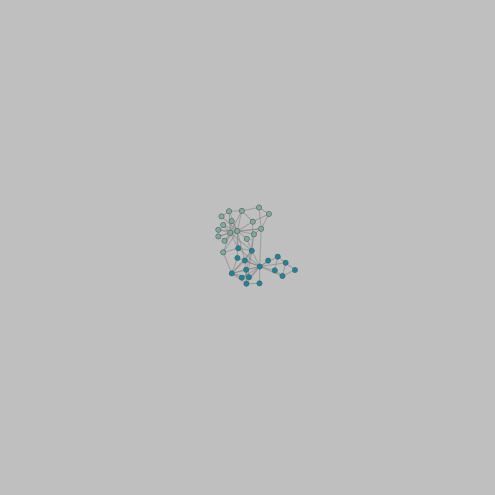

In [3]:
G = nx.karate_club_graph()
with plt.style.context('classic'):
    network, config = visualize(netwulf.get_filtered_network(G, node_group_key='club'), plot_in_cell_below=False)
    fig, ax = netwulf.draw_netwulf(network)
    

Write a function to compute the modularity of a graph partitioning (use equation 9.12 in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.

$$M = \sum_{c=1}^{n_c} \frac{L_{c}}{L} - (\frac{k_c}{2L})^2$$

where $L_c$ is the total number of links within the community $C_c$, and $k_c$ is the total degree of the nodes within this community. And L is the total number of links.


In [4]:
def modularity(G: Graph, partitioning: list) -> float:
    L = len(G.edges())
    M = 0
    for partion in partitioning:
        subgraph = G.subgraph(partion).copy()
        L_c = subgraph.number_of_edges()
        K_c = sum(G.degree[node] for node in subgraph.nodes())
        M += (L_c/L) - (K_c/(2*L))**2
    return M

In [5]:
#Trying making a random partion first
import random
X = [i for i in range(1,35)]
random.shuffle(X)
partitions = [X[17:], X[:17]]
modularity(G, partitions)

-0.061801446416830996

In [6]:
#Making optimal partition based on club splits
hi = {key for (key, value) in dict(nx.get_node_attributes(G, "club")).items() if value == 'Mr. Hi'}
officer = {key for (key, value) in dict(nx.get_node_attributes(G, "club")).items() if value == 'Officer'}

In [7]:
modularity(G, [hi, officer]), nx_comm.modularity(G, [hi, officer])

(0.3582347140039447, 0.3582347140039448)

There is something a bit fishy here. 

Explain in your own words the concept of modularity.
Answer: Modularity is a measure of how much the trace deviates from the trace of a random network. Hence, it is a measure of how much the network deivates from the expected number of edges between communities.

Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a node attribute, called "club".
Answer: Already done look above.

We will now perform a small randomization experiment to assess if the modularity you just computed is statitically different from 0. To do so, we will implement the double edge swap algorithm. The double edge swap algorithm is quite old... it was implemented in 1891 (!) by Danish mathematician Julius Petersen(https://en.wikipedia.org/wiki/Julius_Petersen). Given a network G, this algorithm creates a new network, such that each node has exactly the same degree as in the original network, but different connections. Here is how the algorithm works:
1) Create an identical copy of your original network.
2) Consider two edges in your new network (u,v) and (x,y), such that u!=v and v!=x.
3) If none of edges (u,y) and (x,v) exists already, add them to the network and remove edges (u,v) and (x,y).
Repeat steps b. and c. to achieve at least N swaps (I suggest N to be larger than the number of edges).

In [8]:
def double_edge_swap(G: Graph, N: int)->Graph:
    G_random = G.copy()
    num_swaps = 0
    while num_swaps < N:
        edges = list(G_random.edges)
        non_edges = list(nx.non_edges(G_random))
        (u, v) = random.choice(edges)
        (x, y) = random.choice(edges)
        if u==x or v==y: #Skipping due to same source or target
            continue 
        if (u,x) in non_edges and (v, y) in non_edges:
            G_random.add_edges_from([(u,x), (v, y)])
            G_random.remove_edges_from([(u, v), (x, y)])
            num_swaps += 1
    return G_random

In [9]:
G_random = double_edge_swap(G, G.number_of_edges() + 10) #Pick N > L
sum(dict(G_random.degree()).values()), sum(dict(G.degree()).values())

(156, 156)

Create 1000 randomized version of the Karate Club network using the double edge swap algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list.

In [10]:
random_mods = []
for _ in tqdm(range(1001)):
    G_random = double_edge_swap(G, G.number_of_edges() + 10)
    random_mods.append(modularity(G_random, [hi, officer]))

100%|██████████████████████████████████████████████████████████████████████████| 1001/1001 [01:29<00:00, 11.16it/s]


In [11]:
print(f'The average modularity: {np.mean(random_mods)}, the std: {np.std(random_mods)}')

The average modularity: 0.001386434078741705, the std: 0.04739569454321796


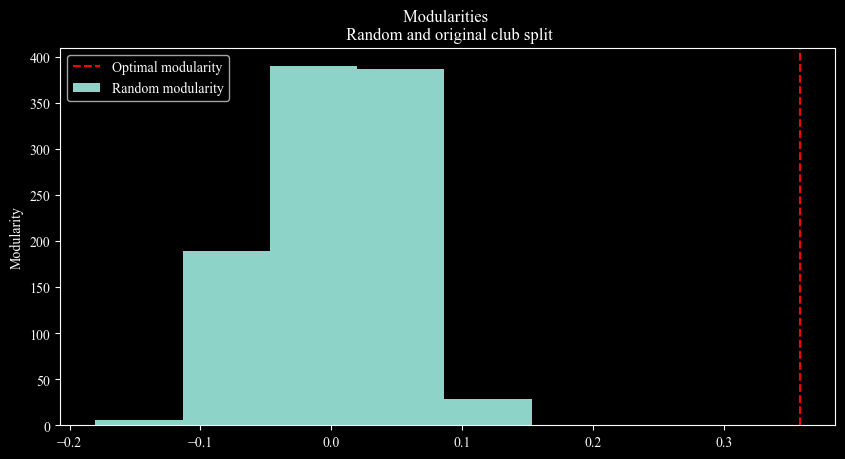

In [12]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.hist(random_mods, label="Random modularity", bins=5)
ax.axvline(modularity(G, [hi, officer]), linestyle='--', color='r', label="Optimal modularity")
ax.set_title("Modularities \n Random and original club split")
ax.set_ylabel("Modularity")
ax.legend()

Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? What is the reason why we preserved the nodes degree?
Answer: It would be justifiable to argue that the club split is a decent partition given that the above visualization demonstrates that it has fewer edges between the two communities than expected at random, which is also the reason why, we perform the randomization experiment. The preservation of node degrees is due to the fact that we meerely swap edges, which entails that when we remove an edge we also add an edge, thereby gaurenteeing preservation of the node degree.

Use the Python Louvain-algorithm implementation to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?

In [14]:
from community import community_louvain

In [28]:
partition = community_louvain.best_partition(G)
partition_dict = {item: set() for (key, item) in partition.items()}
for (key, item) in partition.items():
    partition_dict[item].add(key)
modularity(G, list(partition_dict.values())), modularity(G, [hi, officer])

(0.4188034188034188, 0.3582347140039447)

The modularity is in fact higher for the communities found by the louvain algorithm, which indicates that it is in fact more probable that there is four communities rather than two. This suggest that there is in fact subcommunities within the two karate clubs, which could be believable. The dataset is made on who the individuals interact with outside the karate club, and it could very well be the case that people have joined the karate clubs from different sub communities, which is something we aswell can recognize, I am more likely to join the same karate club as my friend is apart of.

Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix D with dimension (2 times A), where A is the number of communities found by Louvain. We set entry D(i,j) to be the number of nodes that community i has in common with group split j. The matrix D is what we call a confusion matrix. Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

In [33]:
D = np.zeros((2, len(partition_dict.keys())))
for i in range(D.shape[0]):
    for j in range(D.shape[1]):
        D[i, j] = sum([1 for x in partition_dict[j] if x in [hi, officer][i]])
D

array([[ 1., 11.,  0.,  5.],
       [10.,  1.,  6.,  0.]])

We can see that it almost agrees with the club split partitioning but that it has two nodes which it classifies differently. We can then also see that the algorithm finds more communities than the club split as addressed previously.

## Part 2: Comparing partitions
Section 9.6 of the Network Science book dicusses how to test the accuracy of community detection algorithms on networks with predefined community structure. This involves measuring the similarity between the predefined structure and the communities identified by a given community detection algorithm. There are many ways for comparing partitions (for an extensive review, see this article). The book introduces the widely used normalized mutual information (eq. 9.19). We are going to learn more about it and implemement it!

Exercise 2: Mutual Information: In the exercise above, we computed the confusion matrix to compare the communities found by the Louvain method with the "club" split. In this exercise, we will compare the two using the Normalized Mutual Information (see eq. 9.19 in your Network Science Book).

Write a function that, given as input a list of discrete items, returns a dictionary containing the probability of each unique value in the list. For example, given as input the list [1,1,0,1,2], the function should return the following dictionary {1:0.6,0:0.2,2:0.2}.

In [34]:
from collections import Counter
def get_prob(L: list)->dict:
    N = len(L)
    return {key: item/N for (key, item) in Counter(L).items()}

In [35]:
get_prob([1,1,0,1,2])

{1: 0.6, 0: 0.2, 2: 0.2}

Loop through the nodes of your Zachary Karate Club network. For each node, find the corresponding club (either "Mr Hi" or "Officer") and store it in a list l1. Compute the probability p(x) of each club x using the function you computed above.

In [38]:
clubs = list(dict(nx.get_node_attributes(G, "club")).values())
print(f'The probabilities: {get_prob(clubs)}')

The probabilities: {'Mr. Hi': 0.5, 'Officer': 0.5}


In [43]:
l1 = [G.nodes[node]['club'] for node in G.nodes()]
print(f'The probabilities: {get_prob(l1)}')

The probabilities: {'Mr. Hi': 0.5, 'Officer': 0.5}


Loop again through the nodes of your Zachary Karate Club (in the same order as you did in step 1.). For each node, find the corresponding Louvain community, and store it in a list l2. Compute the probability p(y) for each Louvain community y using your function.

In [47]:
l2 = [partition[node] for node in G.nodes()]
print(f'The probabilities: {get_prob(l2)}')

The probabilities: {1: 0.35294117647058826, 3: 0.14705882352941177, 0: 0.3235294117647059, 2: 0.17647058823529413}


Loop again through the nodes of your Zachary Karate Club (in the same order!). This time, build a list of tuples l3, such that the first value in the tuple is club and the second is the Louvain community. Compute the probability p(x,y) for each tuple (x,y) in your list using the function you wrote in step 1.

In [49]:
l3 = [(G.nodes[node]["club"], partition[node]) for node in G.nodes()]
get_prob(l3)

{('Mr. Hi', 1): 0.3235294117647059,
 ('Mr. Hi', 3): 0.14705882352941177,
 ('Mr. Hi', 0): 0.029411764705882353,
 ('Officer', 1): 0.029411764705882353,
 ('Officer', 0): 0.29411764705882354,
 ('Officer', 2): 0.17647058823529413}

Compute the Shannon entropy of the Karate Club split. Remember that the entropy of a variable X
 is defined as H(X)=−∑xp(x)log(p(x))
. Here the sum runs over the two clubs: "Mr Hi" and "Officer". You need the probabilities you computed in step 2.

In [97]:
def entropy(X: list, condition=False)->float:
    probs = get_prob(X)
    entropy = 0
    if condition:
        temp = [y for (x,y) in X]
        probs_y = get_prob(temp)
        for i in probs.keys():
            entropy += probs[i]*np.log(probs[i]/probs_y[i[1]])
    else:
        for i in probs.keys():
            entropy += probs[i]*np.log(probs[i])
    return entropy

In [94]:
entropy(l1)

-0.6931471805599453

In [95]:
entropy(l2)

-1.3206701076815464

In [98]:
entropy(l3, condition=True)

-0.19979496669163377

Now, compute the mutual information I(X;Y)=H(X)−H(X|Y). Compare your result with the results you would obtain applying the scikit-learn function mutual_info_score. You should pass the lists l1 and l2 as inputs to your function.

In [139]:
def entropy(px: dict)->float:
    return -sum(px[i]*np.log(px[i]) for i in px.keys())

def conditional_entropy(pxy: dict, py:dict)->float:
    return -sum(pxy[idx] * np.log(pxy[idx]/py[idx[1]]) for idx in pxy.keys())

In [144]:
def mutual_information(x: dict, y: dict, xy: dict, normalized=False)->float:
    if normalized:
        return (entropy(x) - conditional_entropy(xy, y))/(.5 * entropy(x) + .5 * entropy(y))
    else:
        return entropy(x) - conditional_entropy(xy, y)

In [145]:
#prob of l3 is p_xy and prob of l2 is y
mutual_information(get_prob(l1), get_prob(l2), get_prob(l3))

0.4933522138683115

In [146]:
from sklearn.metrics import mutual_info_score
mutual_info_score(l1, l2)

0.49335221386831196

Compute the normalized mutual information and compare with sklearn:

In [147]:
from sklearn.metrics import normalized_mutual_info_score
normalized_mutual_info_score(l1, l2), mutual_information(get_prob(l1), get_prob(l2), get_prob(l3), normalized=True)

(0.4899672048193782, 0.4899672048193779)

What is the point of normalizing the mutual information through dividing it by $$\frac{1}{2}H(X)+\frac{1}{2}H(Y)$$

Mutual information gives us an estimate of how much information we would gain if we know the variable $Y$ in $I(X,Y)$. However, in order to being able to compare the mutual information score across different partitions which may have different sizes, we have to normalize them. 

We will now perform another randomization test. Shuffle the club split node labels (e.g assign a new group to each node, but keep the size of the "Officer" and "Mr Hi" groups constant). Measure the normalized mutual information with the Louvain communities using the procedure above. Repeat the procedure 1000
 times and plot the distribution of the "random" normalized mutual information

In [181]:
def randomize(G):
    club_dict = dict(nx.get_node_attributes(G, "club"))
    values = list(club_dict.values())
    random.shuffle(values)
    return dict(zip(G.nodes, values))

NMIs = []
for _ in tqdm(range(1001)):
    G_new = G.copy()
    node_mapping = randomize(G_new)
    nx.set_node_attributes(G_new, node_mapping, name="club")
    partition_new = community_louvain.best_partition(G_new)
    x = [G_new.nodes[node]['club'] for node in G_new.nodes()]
    y = [partition_new[node] for node in G_new.nodes()]
    xy = [(G_new.nodes[node]["club"], partition_new[node]) for node in G_new.nodes()]
    NMIs.append(mutual_information(
                            get_prob(x),
                            get_prob(y),
                            get_prob(xy),
                            normalized=True
                        )
               )

100%|█████████████████████████████████████████████████████████████████████████| 1001/1001 [00:02<00:00, 340.38it/s]


In [182]:
np.mean(NMIs), np.std(NMIs)

(0.048328699427241065, 0.03877156375082605)

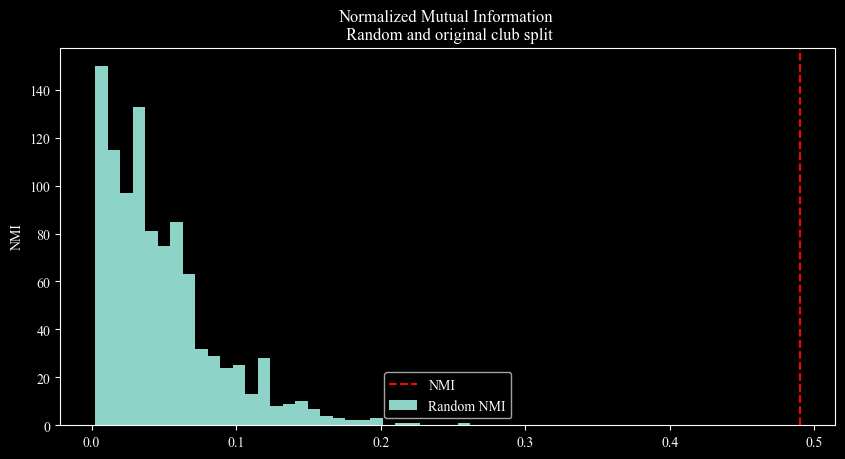

In [183]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.hist(NMIs, label="Random NMI", bins=30)
ax.axvline(mutual_information(get_prob(l1), get_prob(l2), get_prob(l3), normalized=True), linestyle='--', color='r', label="NMI")
ax.set_title("Normalized Mutual Information \n Random and original club split")
ax.set_ylabel("NMI")
ax.legend()

Based on your analysis, what can you conclude about the similarity of the Louvain communities and the actual club split? Why do you think I asked you to run a randomization test?
We can conclude that their is a somewhat correlation between the louvain communities and the club split, given that random permutations of the club split yields far lower Mutual information than the actual split. Thus, we had originally calculated a higher Normalized Mutual Information than expected add random.

## Part 3: communities in the GME network.
Finally, lets' apply community detection to our favourite network: the GME network. In the following, consider the undirected version of the graph.
